In [1]:
import itertools
import numpy
from scipy.spatial import ConvexHull

from matplotlib.collections import LineCollection
from matplotlib import pyplot as plot



# --- Misc. geometry code -----------------------------------------------------

'''
Pick N points uniformly from the unit disc
This sampling algorithm does not use rejection sampling.
'''
def disc_uniform_pick(N):
	angle = (2 * numpy.pi) * numpy.random.random(N)
	out = numpy.stack([numpy.cos(angle), numpy.sin(angle)], axis = 1)
	out *= numpy.sqrt(numpy.random.random(N))[:,None]
	return out



def norm2(X):
	return numpy.sqrt(numpy.sum(X ** 2))



def normalized(X):
	return X / norm2(X)



# --- Delaunay triangulation --------------------------------------------------

def get_triangle_normal(A, B, C):
	return normalized(numpy.cross(A, B) + numpy.cross(B, C) + numpy.cross(C, A))



def get_power_circumcenter(A, B, C):
	N = get_triangle_normal(A, B, C)
	return (-.5 / N[2]) * N[:2]



def is_ccw_triangle(A, B, C):
	M = numpy.concatenate([numpy.stack([A, B, C]), numpy.ones((3, 1))], axis = 1)
	return numpy.linalg.det(M) > 0



def get_power_triangulation(S, R):
	# Compute the lifted weighted points
	S_norm = numpy.sum(S ** 2, axis = 1) - R ** 2
	S_lifted = numpy.concatenate([S, S_norm[:,None]], axis = 1)

	# Special case for 3 points
	if S.shape[0] == 3:
		if is_ccw_triangle(S[0], S[1], S[2]):
			return [[0, 1, 2]], numpy.array([get_power_circumcenter(*S_lifted)])
		else:
			return [[0, 2, 1]], numpy.array([get_power_circumcenter(*S_lifted)])

	# Compute the convex hull of the lifted weighted points
	hull = ConvexHull(S_lifted)

	# Extract the Delaunay triangulation from the lower hull
	tri_list = tuple([a, b, c] if is_ccw_triangle(S[a], S[b], S[c]) else [a, c, b]  for (a, b, c), eq in zip(hull.simplices, hull.equations) if eq[2] <= 0)

	# Compute the Voronoi points
	V = numpy.array([get_power_circumcenter(*S_lifted[tri]) for tri in tri_list])

	# Job done
	return tri_list, V



# --- Compute Voronoi cells ---------------------------------------------------

'''
Compute the segments and half-lines that delimits each Voronoi cell
  * The segments are oriented so that they are in CCW order
  * Each cell is a list of (i, j), (A, U, tmin, tmax) where
     * i, j are the indices of two ends of the segment. Segments end points are
       the circumcenters. If i or j is set to None, then it's an infinite end
     * A is the origin of the segment
     * U is the direction of the segment, as a unit vector
     * tmin is the parameter for the left end of the segment. Can be -1, for minus infinity
     * tmax is the parameter for the right end of the segment. Can be -1, for infinity
     * Therefore, the endpoints are [A + tmin * U, A + tmax * U]
'''
def get_voronoi_cells(S, V, tri_list):
	# Keep track of which circles are included in the triangulation
	vertices_set = frozenset(itertools.chain(*tri_list))

	# Keep track of which edge separate which triangles
	edge_map = { }
	for i, tri in enumerate(tri_list):
		for edge in itertools.combinations(tri, 2):
			edge = tuple(sorted(edge))
			if edge in edge_map:
				edge_map[edge].append(i)
			else:
				edge_map[edge] = [i]

	# For each triangle
	voronoi_cell_map = { i : [] for i in vertices_set }

	for i, (a, b, c) in enumerate(tri_list):
		# For each edge of the triangle
		for u, v, w in ((a, b, c), (b, c, a), (c, a, b)):
		# Finite Voronoi edge
			edge = tuple(sorted((u, v)))
			if len(edge_map[edge]) == 2:
				j, k = edge_map[edge]
				if k == i:
					j, k = k, j

				# Compute the segment parameters
				U = V[k] - V[j]
				U_norm = norm2(U)

				# Add the segment
				voronoi_cell_map[u].append(((j, k), (V[j], U / U_norm, 0, U_norm)))
			else:
			# Infinite Voronoi edge
				# Compute the segment parameters
				A, B, C, D = S[u], S[v], S[w], V[i]
				U = normalized(B - A)
				I = A + numpy.dot(D - A, U) * U
				W = normalized(I - D)
				if numpy.dot(W, I - C) < 0:
					W = -W

				# Add the segment
				voronoi_cell_map[u].append(((edge_map[edge][0], -1), (D,  W, 0, None)))
				voronoi_cell_map[v].append(((-1, edge_map[edge][0]), (D, -W, None, 0)))

	# Order the segments
	def order_segment_list(segment_list):
		# Pick the first element
		first = min((seg[0][0], i) for i, seg in enumerate(segment_list))[1]

		# In-place ordering
		segment_list[0], segment_list[first] = segment_list[first], segment_list[0]
		for i in range(len(segment_list) - 1):
			for j in range(i + 1, len(segment_list)):
				if segment_list[i][0][1] == segment_list[j][0][0]:
					segment_list[i+1], segment_list[j] = segment_list[j], segment_list[i+1]
					break

		# Job done
		return segment_list

	# Job done
	return { i : order_segment_list(segment_list) for i, segment_list in voronoi_cell_map.items() }



# --- Plot all the things -----------------------------------------------------

def display(S, R, tri_list, voronoi_cell_map):
	# Setup
	fig, ax = plot.subplots()
	plot.axis('equal')
	plot.axis('off')

	# Set min/max display size, as Matplotlib does it wrong
	min_corner = numpy.amin(S, axis = 0) - numpy.max(R)
	max_corner = numpy.amax(S, axis = 0) + numpy.max(R)
	plot.xlim((min_corner[0], max_corner[0]))
	plot.ylim((min_corner[1], max_corner[1]))

	# Plot the samples
	for Si, Ri in zip(S, R):
		ax.add_artist(plot.Circle(Si, Ri, fill = True, alpha = .4, lw = 0., color = '#8080f0', zorder = 1))

	# Plot the power triangulation
	edge_set = frozenset(tuple(sorted(edge)) for tri in tri_list for edge in itertools.combinations(tri, 2))
	line_list = LineCollection([(S[i], S[j]) for i, j in edge_set], lw = 1., colors = '.9')
	line_list.set_zorder(0)
	ax.add_collection(line_list)

	# Plot the Voronoi cells
	edge_map = { }
	for segment_list in voronoi_cell_map.values():
		for edge, (A, U, tmin, tmax) in segment_list:
			edge = tuple(sorted(edge))
			if edge not in edge_map:
				if tmax is None:
					tmax = 10
				if tmin is None:
					tmin = -10

				edge_map[edge] = (A + tmin * U, A + tmax * U)

	line_list = LineCollection(edge_map.values(), lw = 1., colors = 'k')
	line_list.set_zorder(0)
	ax.add_collection(line_list)

	# Job done
	plot.show()



# --- Main entry point --------------------------------------------------------

def main():
	# Generate samples, S contains circles center, R contains circles radius
	sample_count = 32
	S = 5 * disc_uniform_pick(sample_count)
	R = .8 * numpy.random.random(sample_count) + .2

	# Compute the power triangulation of the circles
	tri_list, V = get_power_triangulation(S, R)

	# Compute the Voronoi cells
	voronoi_cell_map = get_voronoi_cells(S, V, tri_list)

	# Display the result
	display(S, R, tri_list, voronoi_cell_map)

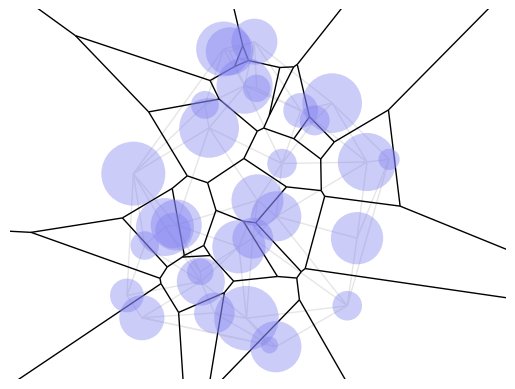

In [5]:
# Generate samples, S contains circles center, R contains circles radius
sample_count = 32
S = 5 * disc_uniform_pick(sample_count)
R = .8 * numpy.random.random(sample_count) + .2

# Compute the power triangulation of the circles
tri_list, V = get_power_triangulation(S, R)

# Compute the Voronoi cells
voronoi_cell_map = get_voronoi_cells(S, V, tri_list)

# Display the result
display(S, R, tri_list, voronoi_cell_map)

In [7]:
tri_list, V

(([3, 20, 27],
  [3, 21, 20],
  [22, 14, 5],
  [15, 21, 18],
  [26, 3, 27],
  [6, 12, 13],
  [0, 20, 21],
  [0, 21, 15],
  [10, 21, 3],
  [10, 31, 21],
  [4, 26, 5],
  [4, 3, 26],
  [4, 10, 3],
  [4, 31, 10],
  [1, 22, 5],
  [1, 5, 26],
  [8, 12, 23],
  [24, 18, 7],
  [24, 15, 18],
  [24, 0, 15],
  [28, 5, 14],
  [28, 14, 4],
  [28, 4, 5],
  [29, 14, 31],
  [29, 4, 14],
  [29, 31, 4],
  [25, 1, 26],
  [25, 6, 13],
  [25, 13, 22],
  [25, 22, 1],
  [30, 7, 8],
  [30, 8, 23],
  [9, 24, 7],
  [9, 23, 24],
  [9, 7, 30],
  [9, 30, 23],
  [17, 20, 0],
  [17, 0, 24],
  [11, 24, 23],
  [11, 17, 24],
  [11, 27, 20],
  [11, 20, 17],
  [2, 23, 12],
  [2, 11, 23],
  [2, 27, 11],
  [16, 12, 6],
  [16, 2, 12],
  [16, 27, 2],
  [16, 26, 27],
  [16, 25, 26],
  [16, 6, 25]),
 array([[ -0.96131167,   0.22199695],
        [ -1.58930088,   0.4347018 ],
        [  1.80617795,   3.87331942],
        [ -6.40897535,  -1.30983785],
        [  0.16029073,   0.97105714],
        [ 13.98264907,  -4.1580046 ],
    

In [12]:
R

array([0.89414584, 0.46367753, 0.63004089, 0.92102039, 0.86635997,
       0.53772038, 0.80685716, 0.69705105, 0.79043732, 0.62612956,
       0.43089634, 0.82235928, 0.45649248, 0.32818681, 0.71004039,
       0.44079377, 0.77478243, 0.41012053, 0.52140808, 0.55013206,
       0.78699177, 0.98813097, 0.91953453, 0.99633885, 0.74202276,
       0.89741438, 0.45582934, 0.80322854, 0.42352414, 0.74147072,
       0.26097631, 0.84713446])

In [15]:
'''
Compute the segments and half-lines that delimits each Voronoi cell
  * The segments are oriented so that they are in CCW order
  * Each cell is a list of (i, j), (A, U, tmin, tmax) where
     * i, j are the indices of two ends of the segment. Segments end points are
       the circumcenters. If i or j is set to None, then it's an infinite end
     * A is the origin of the segment
     * U is the direction of the segment, as a unit vector
     * tmin is the parameter for the left end of the segment. Can be -1, for minus infinity
     * tmax is the parameter for the right end of the segment. Can be -1, for infinity
     * Therefore, the endpoints are [A + tmin * U, A + tmax * U]
'''
""

''

In [10]:
voronoi_cell_map[1]

[((14, 29),
  (array([2.18370655, 2.2577911 ]),
   array([ 0.70227525, -0.71190553]),
   0,
   1.0905094035675313)),
 ((29, 26),
  (array([2.94954431, 1.48145143]),
   array([-0.62252418, -0.78260056]),
   0,
   0.673109929485412)),
 ((26, 15),
  (array([2.5305171 , 0.95467522]),
   array([-0.79742581,  0.603417  ]),
   0,
   1.0386972166753574)),
 ((15, 14),
  (array([1.70223313, 1.58144278]),
   array([0.57993539, 0.81466247]),
   0,
   0.8302190670446152))]

In [36]:
from geometry.circle import Circle
from geometry.coord import Coord
from geometry.polygon import Polygon
import numpy as np
import shapely
from scipy.spatial import Voronoi
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import polygonize,unary_union
from shapely.geometry import LineString, MultiPolygon, MultiPoint, Point
from scipy.spatial import voronoi_plot_2d


circles = [Circle(Coord(100, 100), 50), Circle(Coord(200, 300), 60), Circle(Coord(300, 60), 50), Circle(Coord(400, 100), 50), Circle(Coord(500, 500), 100), Circle(Coord(600, 250), 50), Circle(Coord(380, 300), 50), Circle(Coord(300, 200), 25)]

In [37]:
world = Polygon([Coord(0, 0), Coord(0, 1000), Coord(1000, 1000), Coord(1000, 0)])

coords = [c.center for c in circles]
np_coords = np.array([coord.xy for coord in coords])

vor = Voronoi(points=np_coords)

vertices
[[509.         358.6       ]
 [474.88372093 208.48837209]
 [290.         490.        ]
 [401.11111111 201.11111111]
 [290.         290.        ]
 [183.33333333 183.33333333]
 [210.         130.        ]
 [330.         130.        ]]
regions
[[-1, array([509. , 358.6]), array([474.88372093, 208.48837209])], [-1, array([509. , 358.6]), array([290., 490.])], [array([290., 290.]), array([290., 490.]), array([509. , 358.6]), array([474.88372093, 208.48837209]), array([401.11111111, 201.11111111])], [array([183.33333333, 183.33333333]), -1, array([290., 490.]), array([290., 290.])], [-1, array([330., 130.]), array([210., 130.])], [array([330., 130.]), array([401.11111111, 201.11111111]), array([290., 290.]), array([183.33333333, 183.33333333]), array([210., 130.])], [-1, array([183.33333333, 183.33333333]), array([210., 130.])], [-1, array([474.88372093, 208.48837209]), array([401.11111111, 201.11111111]), array([330., 130.])], []]


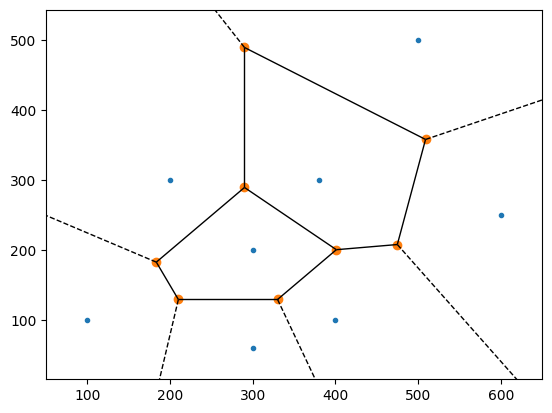

In [41]:
print('vertices')
print(vor.vertices)

print('regions')
print([[vor.vertices[i] if i != -1 else -1 for i in region] for region in vor.regions])

fig = voronoi_plot_2d(vor)
plt.show()

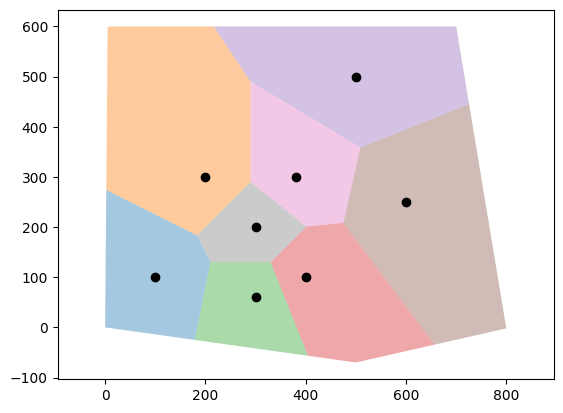

In [52]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# make up data points
np.random.seed(1234)
points = np_coords

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

# min_x = vor.min_bound[0] - 0.1
# max_x = vor.max_bound[0] + 0.1
# min_y = vor.min_bound[1] - 0.1
# max_y = vor.max_bound[1] + 0.1

box = shapely.geometry.Polygon([(0,0), (5,600), (700,600), (800,-2), (500,-70)])

# mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
# bounded_vertices = np.max((vertices, mins), axis=0)
# maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
# bounded_vertices = np.min((bounded_vertices, maxs), axis=0)



# box = Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

# colorize
for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = Polygon(polygon)
    poly = poly.intersection(box)
    polygon = [p for p in poly.exterior.coords]

    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:, 0], points[:, 1], 'ko')
plt.axis('equal')
# plt.xlim(-100, 900)
# plt.ylim(-100, 700)

plt.savefig('voro.png')
plt.show()